## Vasileios

In [8]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=0, which="LM", return_eigenvectors=False
                )
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
            candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
            candidates.append(candidate)

    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=0, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [9]:
import kwant
import tinyarray
import numpy as np
import scipy as spi

import matplotlib.pyplot as plt 
import matplotlib.colors as colors

In [205]:
## function for phase-on-delta implementation

def make_system(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, tau=0.5, phi=0, L=1):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_x
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_x
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_x
    lead0[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_x
    lead1[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [199]:
## function for phase-on-delta implementation

def make_system(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, tau=0.5, phi=0, L=3):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    syst[(lat(x) for x in range(1, L+1))] = (mu-2.*t)*tau_z + B*sigma_z
    syst[(lat(0))] = (mu-2.*t)*tau_z + B*sigma_z + np.matmul(spi.linalg.expm(phi*1j*tau_z/2.), delta*tau_x)
    syst[(lat(L+1))] = (mu-2.*t)*tau_z + B*sigma_z + np.matmul(spi.linalg.expm(-phi*1j*tau_z/2.), delta*tau_x)
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = t*tau_z
    syst[(lat(0), lat(1))] = tau*t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    syst[(lat(L), lat(L+1))] = tau*t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + np.matmul(spi.linalg.expm(phi*1j*tau_z/2.), delta*tau_x)
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+2))] =  (mu-2.*t)*tau_z + B*sigma_z + np.matmul(spi.linalg.expm(-phi*1j*tau_z/2.), delta*tau_x)
    lead1[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [235]:
## function for phase-on-delta implementation

def make_system(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, tau=0.5, phi=0, L=1):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [125]:
## function for phase-on-delta implementation

#finite implementation
# a = 6.479 A from http://www.ioffe.ru/SVA/NSM/Semicond/InSb/basic.html
# energies in units of meV, lengths in units of A, mass in units of free electron mass 9.11e-31 kg

def make_system(mu=0.5,
                m=0.015, B=1., delta=0.25, alpha_so=20, tau=0.5, phi=0, L_link=3, a=6.479, L_S=2.2, tv=-1.):
    #a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    #consts
    h_bar = 1.05e-34
    m_e = 9.11e-31
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    
    #### Define params ####
    L = int(L_link)
    L_s = int(np.around(L_S*10000./a))
    t = (h_bar**2.)/(2.*m*m_e*((a*1e-10)**2.))/1.6e-19*1000.
    t=tv
    print(t)
    print(L)
    print(L_s)
    
    #### Define the scattering region. ####
    syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    
    #### Define the leads. ####
    '''sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)'''

    return syst.finalized()

In [160]:
## function for phase-on-delta implementation

#infinite implementation
# a = 6.479 A from http://www.ioffe.ru/SVA/NSM/Semicond/InSb/basic.html
# energies in units of meV, lengths in units of A, mass in units of free electron mass 9.11e-31 kg

def make_system(mu=0.5,
                m=0.015, B=1., delta=0.25, alpha_so=20, tau=0.5, phi=0, L_link=3, a=6.479, L_S=2.2, tv=-1.):
    #a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    #consts
    h_bar = 1.05e-34
    m_e = 9.11e-31
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    
    #### Define params ####
    L = int(L_link)
    L_s = int(np.around(L_S*10000./a))
    t = (h_bar**2.)/(2.*m*m_e*((a*1e-10)**2.))/1.6e-19*1000.
    t=tv
    print(t)
    print(L)
    print(L_s)
    
    #### Define the scattering region. ####
    syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [124]:
from types import SimpleNamespace as sns

def SNS_avila(p,L=50,phi=0,transp=1,L_S=500):
    if not 0<=transp<=1:
        raise Exception('Transparency must be between 0 and 1!')
    
    a=p.a
    B=p.B
    mu=p.mu
    alpha=p.alpha
    gap=p.gap
    t=p.t
    
    t_s=t #t in same region
    t_i=t*transp #t at interface. currently unused since no leads
    
    # Pauli matrices
    tau_0 = np.kron(np.eye(2), np.eye(2))
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_0 = np.kron(np.eye(2), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #phase and delta should mix in particle hole space
    h_l=(2*t_s-mu)*tau_z@sigma_0+B*tau_z@sigma_x+gap*sp.linalg.expm(-phi*1j*tau_z/2)@tau_y@sigma_y
    h_r=(2*t_s-mu)*tau_z@sigma_0+B*tau_z@sigma_x+gap*sp.linalg.expm(phi*1j*tau_z/2)@tau_y@sigma_y
    h_n=(2*t_s-mu)*tau_z@sigma_0+B*tau_z@sigma_x
    v_s=-t_s*tau_z@sigma_0-1j*alpha/(2*a)*tau_z@sigma_y #same 
    v_i=-t_i*tau_z@sigma_0-1j*alpha/(2*a)*tau_z@sigma_y #interface hopping
    #alpha term is of a different sign

    JJ=kwant.Builder()
    lat = kwant.lattice.chain(a)
    
    #on-site potentials
    JJ[(lat(x) for x in range(L_S,L_S+L))] = h_n
    JJ[(lat(x) for x in range(L_S))]=h_l
    JJ[(lat(x) for x in range(L_S+L,2*L_S+L))]=h_r

    #hoppings
    JJ[lat.neighbors()] = v_s.conj().T
    JJ[lat(L_S-1),lat(L_S)]=v_i
    JJ[lat(L_S+L-1),lat(L_S+L)]=v_i
    
    return JJ.finalized()

In [121]:
test_arr = np.array([[1., 0.25+1j], [0.5+2j, -1]])
print(test_arr)
print(np.conj(test_arr))
print(test_arr.conj().T)

[[ 1.  +0.j  0.25+1.j]
 [ 0.5 +2.j -1.  +0.j]]
[[ 1.  -0.j  0.25-1.j]
 [ 0.5 -2.j -1.  -0.j]]
[[ 1.  -0.j  0.5 -2.j]
 [ 0.25-1.j -1.  -0.j]]


In [123]:
p = sns(t=1, mu=0.5, alpha=6.479/2., gap=0.25,a=6.479,B=1.)
SNS_avila(p, L=0, L_S=50).hamiltonian(0, 1)

v_s
[[-1.  +0.j -0.25+0.j  0.  +0.j  0.  +0.j]
 [ 0.25+0.j -1.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  1.  +0.j  0.25+0.j]
 [ 0.  +0.j  0.  +0.j -0.25+0.j  1.  +0.j]]
v_s conj
[[-1.  -0.j -0.25-0.j  0.  -0.j  0.  -0.j]
 [ 0.25-0.j -1.  -0.j  0.  -0.j  0.  -0.j]
 [ 0.  -0.j  0.  -0.j  1.  -0.j  0.25-0.j]
 [ 0.  -0.j  0.  -0.j -0.25-0.j  1.  -0.j]]
tau_zsigma_y
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]]


array([[-1.  +0.j, -0.25+0.j,  0.  +0.j,  0.  +0.j],
       [ 0.25+0.j, -1.  +0.j,  0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  1.  +0.j,  0.25+0.j],
       [ 0.  +0.j,  0.  +0.j, -0.25+0.j,  1.  +0.j]])

In [103]:
make_system(alpha_so=6.479/2., L_link=0, L_S=50, tv=1., B=1.).hamiltonian(0, 1)

1.0
0
77172
V_s
[[-1.  +0.j -0.25+0.j -0.  +0.j -0.  +0.j]
 [ 0.25+0.j -1.  +0.j -0.  +0.j -0.  +0.j]
 [-0.  +0.j -0.  +0.j  1.  +0.j  0.25+0.j]
 [-0.  +0.j -0.  +0.j -0.25+0.j  1.  +0.j]]
tau_zsigma_y
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]]


array([[-1.  +0.j, -0.25+0.j, -0.  +0.j, -0.  +0.j],
       [ 0.25+0.j, -1.  +0.j, -0.  +0.j, -0.  +0.j],
       [-0.  +0.j, -0.  +0.j,  1.  +0.j,  0.25+0.j],
       [-0.  +0.j, -0.  +0.j, -0.25+0.j,  1.  +0.j]])

In [209]:
# Pauli matrices
tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))


print(sigma_z)
print(tau_z@sigma_x)

t_x = np.array([[0, 1], [1, 0]])
t_y = np.array([[0, -1j], [1j, 0]])
t_z = np.array([[1, 0], [0, -1]])

print(np.kron(t_z, t_x))
print(1j*sigma_y)
print(tau_y@sigma_y)
print(tau_x)
print(1j*tau_z@sigma_y)
print(tau_z)
phi=-0.5*np.pi
spi.linalg.expm(phi*1j*tau_z)@tau_x

[[ 1.  0.  0.  0.]
 [ 0. -1.  0. -0.]
 [ 0.  0.  1.  0.]
 [ 0. -0.  0. -1.]]
[[ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]]
[[ 0  1  0  0]
 [ 1  0  0  0]
 [ 0  0  0 -1]
 [ 0  0 -1  0]]
[[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]]
[[ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]]
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
[[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1. -0.]
 [ 0.  0. -0. -1.]]


array([[0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]])

[[ 1.5      +0.j         1.       +0.j         0.       +0.j        ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]
 [ 1.       +0.j         1.5      +0.j         0.1767767+0.1767767j ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]
 [ 0.       +0.j         0.1767767-0.1767767j -1.5      +0.j        ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]
 ...
 [ 0.       +0.j         0.       +0.j         0.       +0.j        ...
   1.5      +0.j         0.1767767-0.1767767j  0.       +0.j       ]
 [ 0.       +0.j         0.       +0.j         0.       +0.j        ...
   0.1767767+0.1767767j -1.5      +0.j        -1.       +0.j       ]
 [ 0.       +0.j         0.       +0.j         0.       +0.j        ...
   0.       +0.j        -1.       +0.j        -1.5      +0.j       ]]


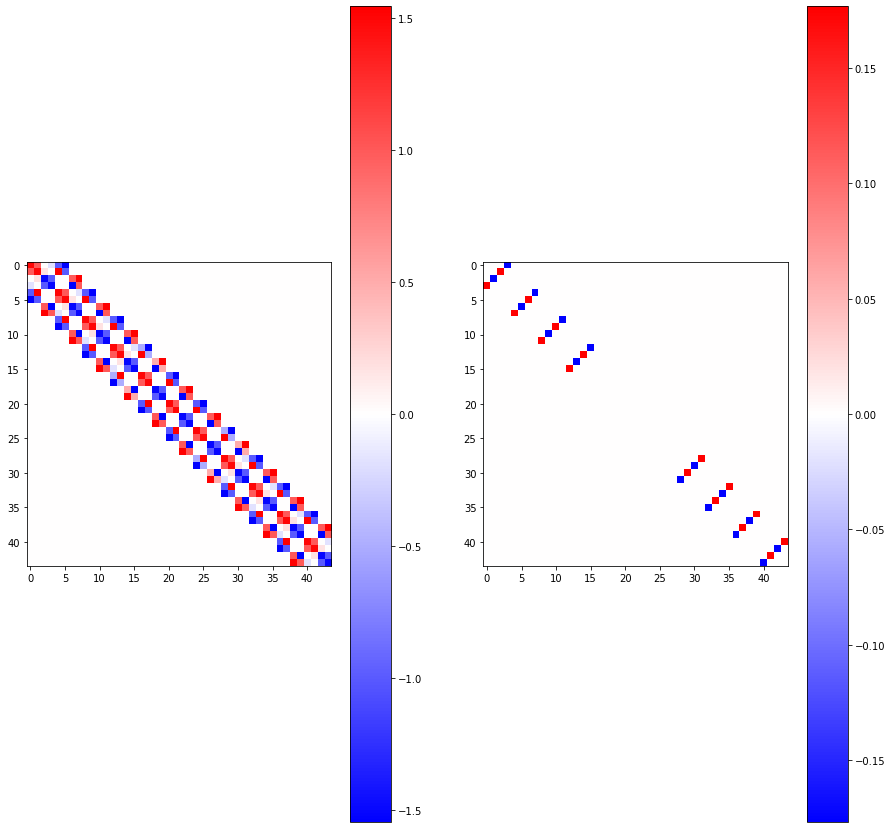

In [14]:
syst = make_system(L_link=3, phi=0.5*np.pi, L_S=2.2e-3)
#kwant.plot(syst)
ham_bdg = syst.hamiltonian_submatrix()

norm1 = colors.DivergingNorm(vcenter=0)
norm2 = colors.DivergingNorm(vcenter=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
im1 = ax1.imshow(np.real(ham_bdg), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(ham_bdg), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
print(ham_bdg)

0.0
0.01790143749839361
0.03580287499678722
0.05370431249518083
0.07160574999357444
0.08950718749196805
0.10740862499036166
0.12531006248875526
0.14321149998714888
0.1611129374855425
0.1790143749839361
0.1969158124823297
0.21481724998072332
0.23271868747911695
0.2506201249775105
0.26852156247590414
0.28642299997429777
0.3043244374726914
0.322225874971085
0.3401273124694786
0.3580287499678722
0.37593018746626583
0.3938316249646594
0.411733062463053
0.42963449996144665
0.44753593745984027
0.4654373749582339
0.48333881245662746
0.501240249955021
0.5191416874534147
0.5370431249518083
0.554944562450202
0.5728459999485955
0.5907474374469891
0.6086488749453828
0.6265503124437763
0.64445174994217
0.6623531874405636
0.6802546249389572
0.6981560624373508
0.7160574999357444
0.733958937434138
0.7518603749325317
0.7697618124309252
0.7876632499293188
0.8055646874277125
0.823466124926106
0.8413675624244997
0.8592689999228933
0.8771704374212869
0.8950718749196805
0.9129733124180741
0.9308747499164678


Text(0.5, 1.0, '$L_S = 50, L=10, \\mu=0.5, \\Delta=0.5, \\alpha_{so}=3.240, a=6.479, \\tau = -1, t = 1$')

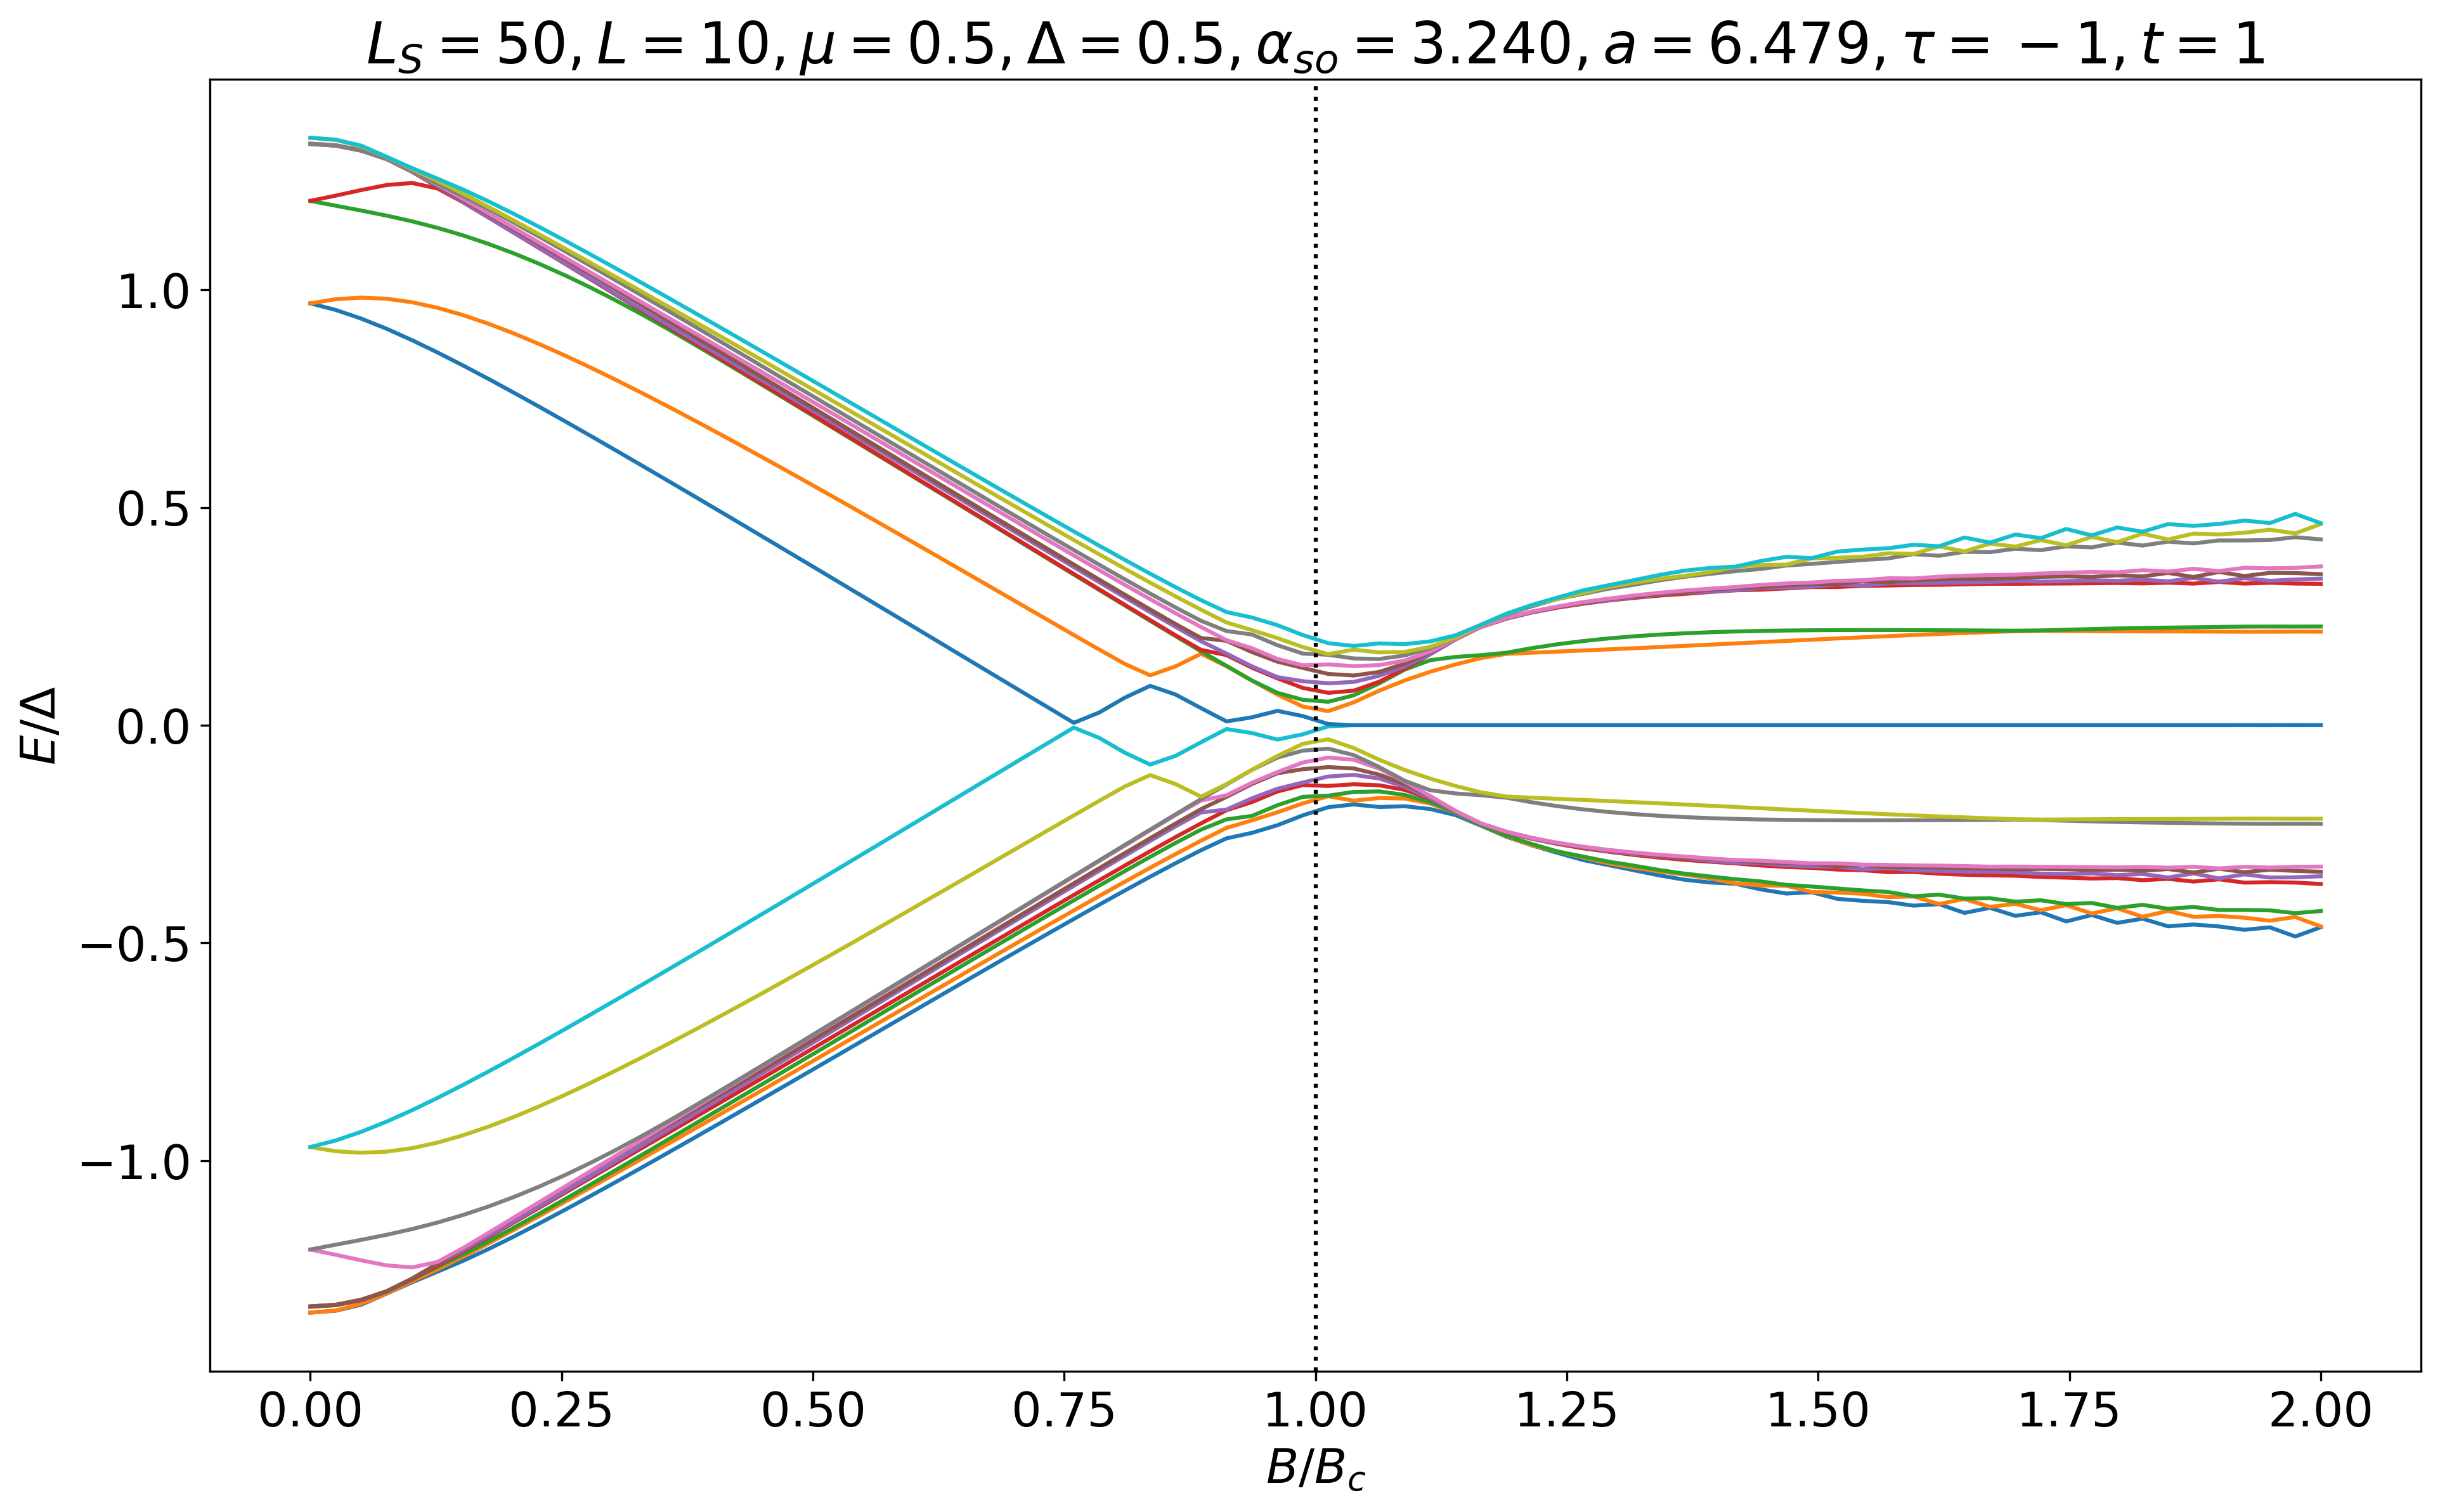

In [132]:
# Calculate and plot lowest eigenenergies in B-field.
delta = 0.5
B_c = np.sqrt(0.5**2. + 0.5**2.)
B_values = np.linspace(0, 2*B_c, 80)
energies = []
for B in B_values:
    print(B)
    p = sns(t=-1, mu=0.5, alpha=6.479/2., gap=0.5,a=6.479,B=B)
    syst = SNS_avila(p, L=10, L_S=50)  
    H = syst.hamiltonian_submatrix(sparse=True).tocsc()
    eigs = sp.linalg.eigsh(H, k=20, sigma=0., which='LM')
    energies.append(np.sort(eigs[0]))
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15, 9), dpi=300)
plt.plot(B_values/B_c, np.array(energies)/delta)
plt.axvline(1., color='k', linestyle=':')
plt.xlabel(r'$B/B_c$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$L_S = 50, L=10, \mu=0.5, \Delta=0.5, \alpha_{so}=3.240, a=6.479, \tau = -1, t = 1$')
#pyplot.show()

0.0
-1.0
0
50
0.014152328971517657
-1.0
0
50
0.028304657943035313
-1.0
0
50
0.04245698691455297
-1.0
0
50
0.05660931588607063
-1.0
0
50
0.07076164485758829
-1.0
0
50
0.08491397382910594
-1.0
0
50
0.09906630280062359
-1.0
0
50
0.11321863177214125
-1.0
0
50
0.12737096074365892
-1.0
0
50
0.14152328971517658
-1.0
0
50
0.15567561868669422
-1.0
0
50
0.16982794765821188
-1.0
0
50
0.18398027662972954
-1.0
0
50
0.19813260560124718
-1.0
0
50
0.21228493457276484
-1.0
0
50
0.2264372635442825
-1.0
0
50
0.24058959251580017
-1.0
0
50
0.25474192148731784
-1.0
0
50
0.26889425045883547
-1.0
0
50
0.28304657943035316
-1.0
0
50
0.2971989084018708
-1.0
0
50
0.31135123737338843
-1.0
0
50
0.3255035663449061
-1.0
0
50
0.33965589531642376
-1.0
0
50
0.3538082242879414
-1.0
0
50
0.3679605532594591
-1.0
0
50
0.3821128822309767
-1.0
0
50
0.39626521120249436
-1.0
0
50
0.41041754017401205
-1.0
0
50
0.4245698691455297
-1.0
0
50
0.4387221981170474
-1.0
0
50
0.452874527088565
-1.0
0
50
0.46702685606008265
-1.0
0
50
0.48

Text(0.5, 1.0, '$L_S = 50, L=10, \\mu=0.5, \\Delta=0.25, \\alpha_{so}=3.240, a=6.479, \\tau = 1, t = 1$')

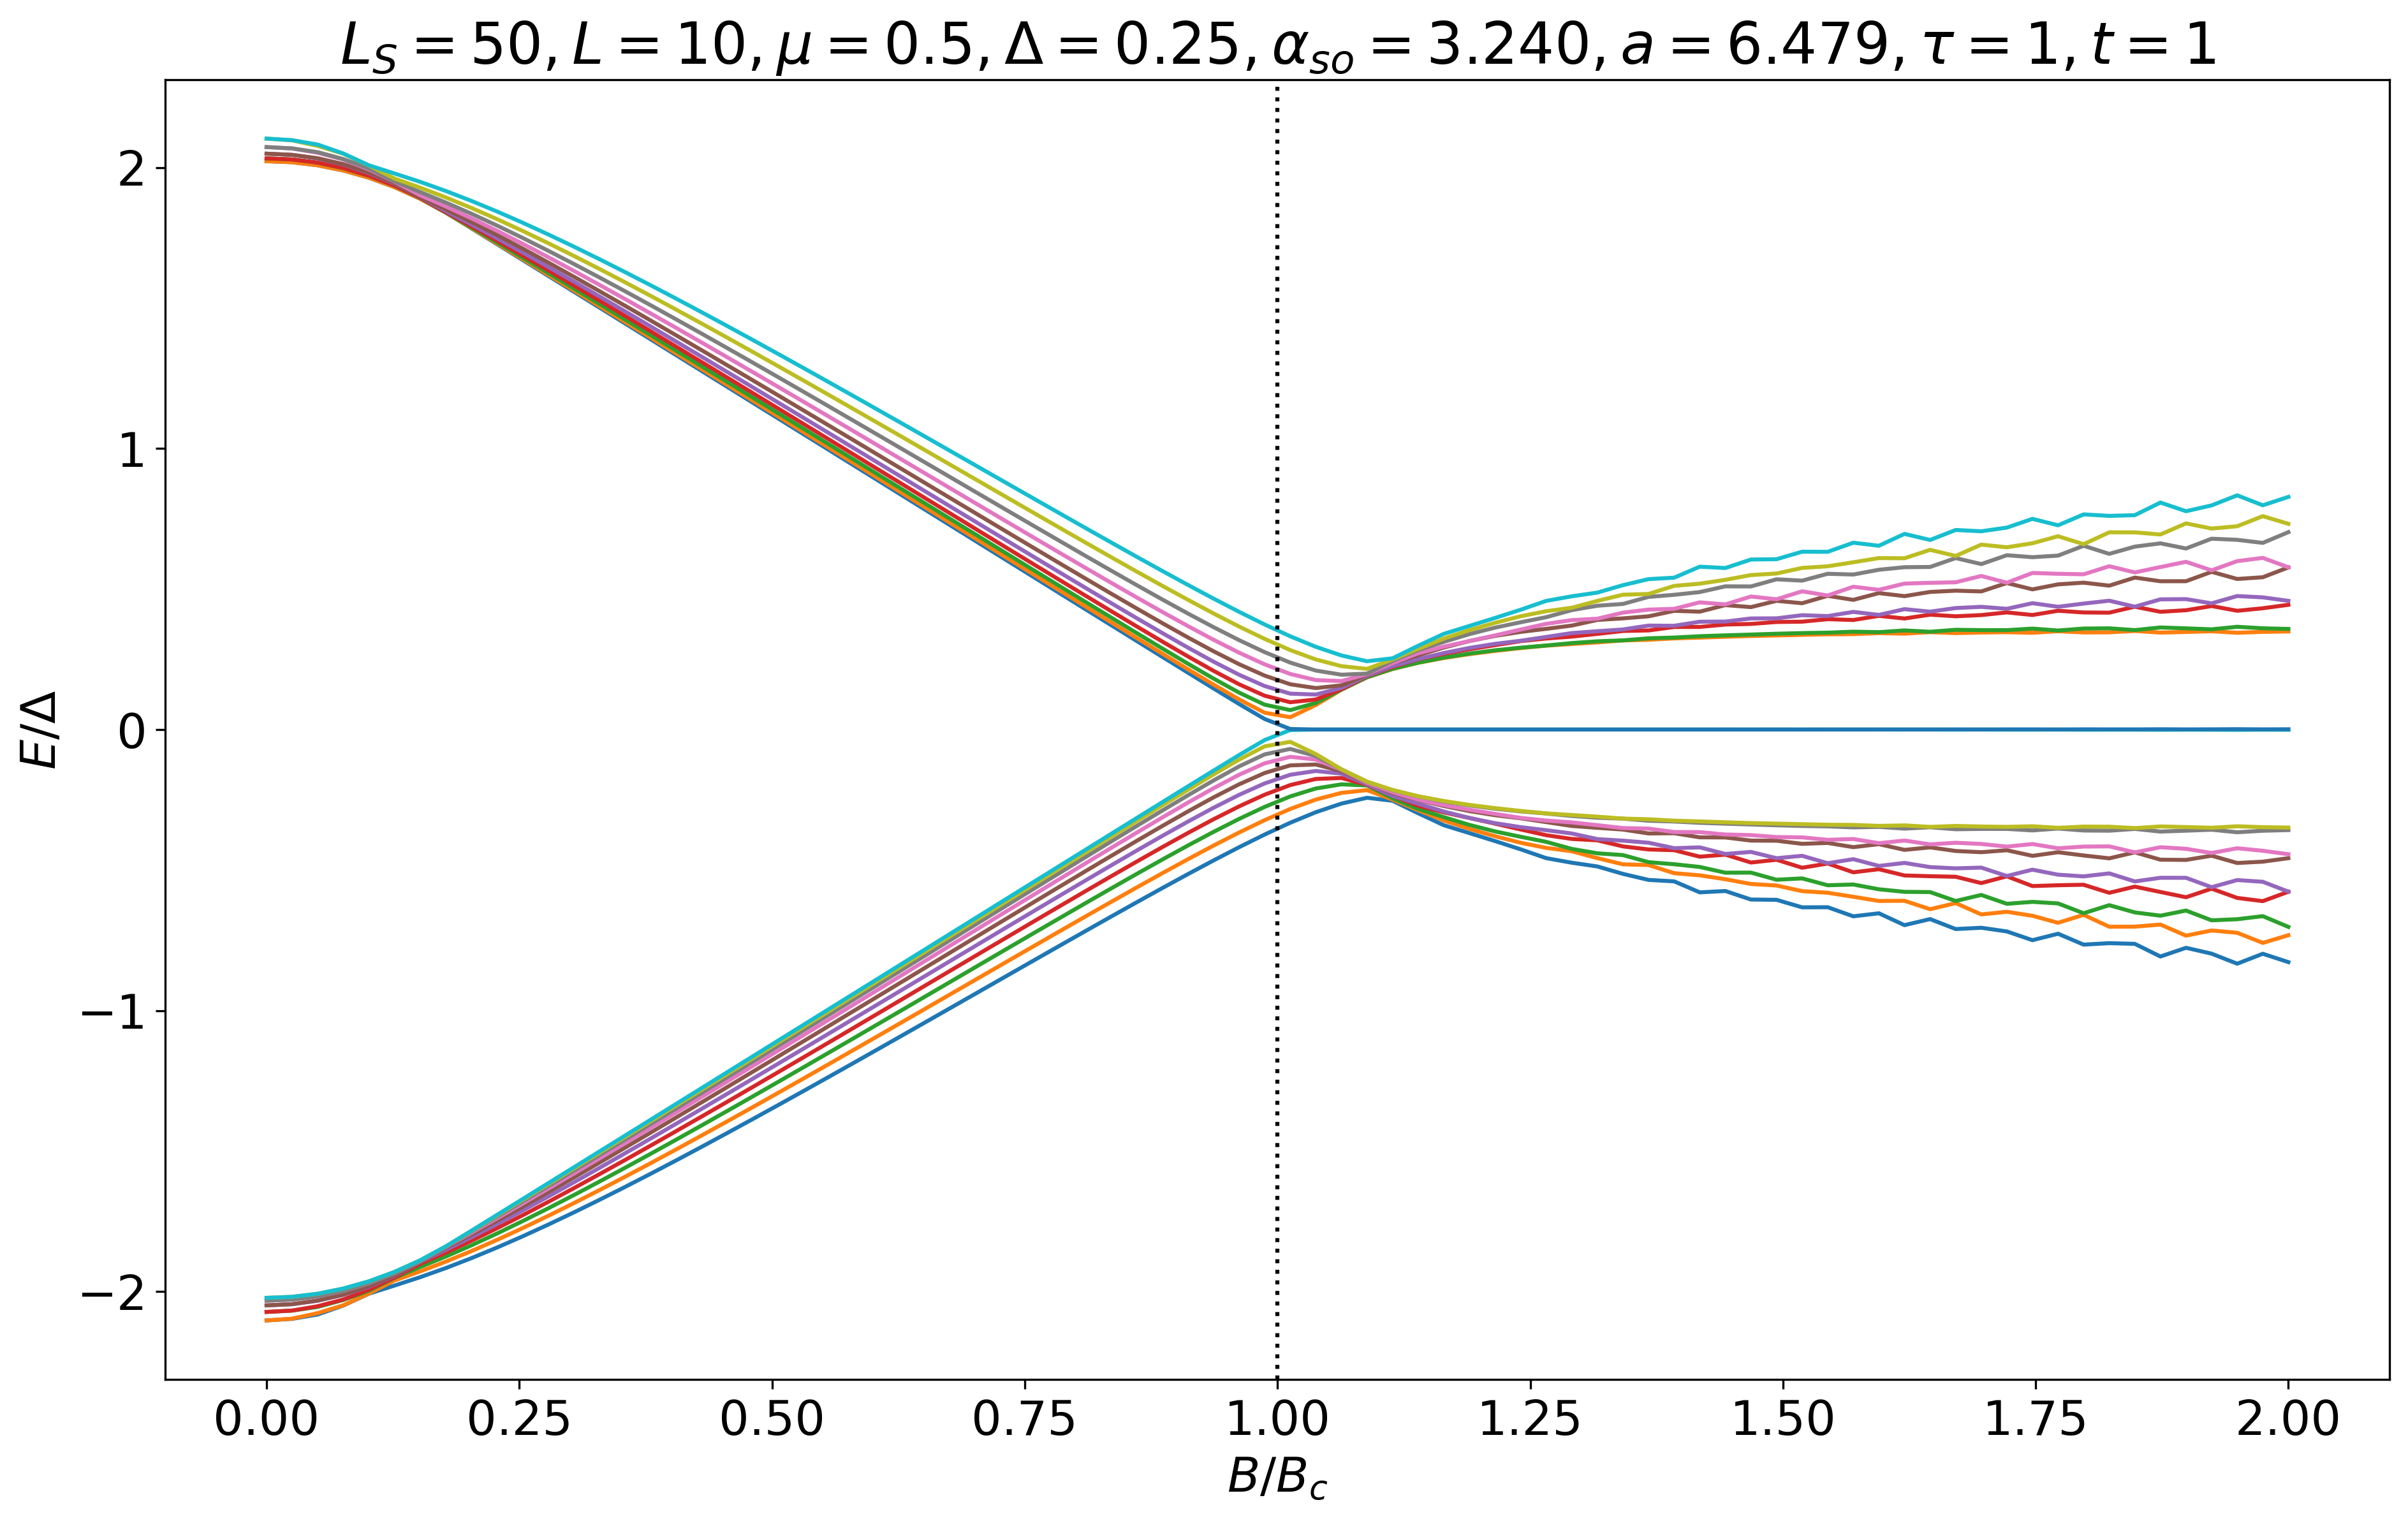

In [136]:
# Calculate and plot lowest eigenenergies in B-field.
delta = 0.25
B_c = np.sqrt(0.5**2. + 0.25**2.)
B_values = np.linspace(0, 2*B_c, 80)
energies = []
for B in B_values:
    print(B)
    syst = make_system(B=B, L_link=0, L_S=6.479*50./10000., tau=1., tv=-1., alpha_so=6.479/2., delta=0.25)  
    H = syst.hamiltonian_submatrix(sparse=True).tocsc()
    eigs = sp.linalg.eigsh(H, k=20, sigma=0., which='LM')
    energies.append(np.sort(eigs[0]))
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15, 9), dpi=300)
plt.plot(B_values/B_c, np.array(energies)/delta)
plt.axvline(1., color='k', linestyle=':')
plt.xlabel(r'$B/B_c$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$L_S = 50, L=10, \mu=0.5, \Delta=0.25, \alpha_{so}=3.240, a=6.479, \tau = 1, t = -1$')
#pyplot.show()

1.0
100
50


TypeError: '>' not supported between instances of 'NoneType' and 'int'

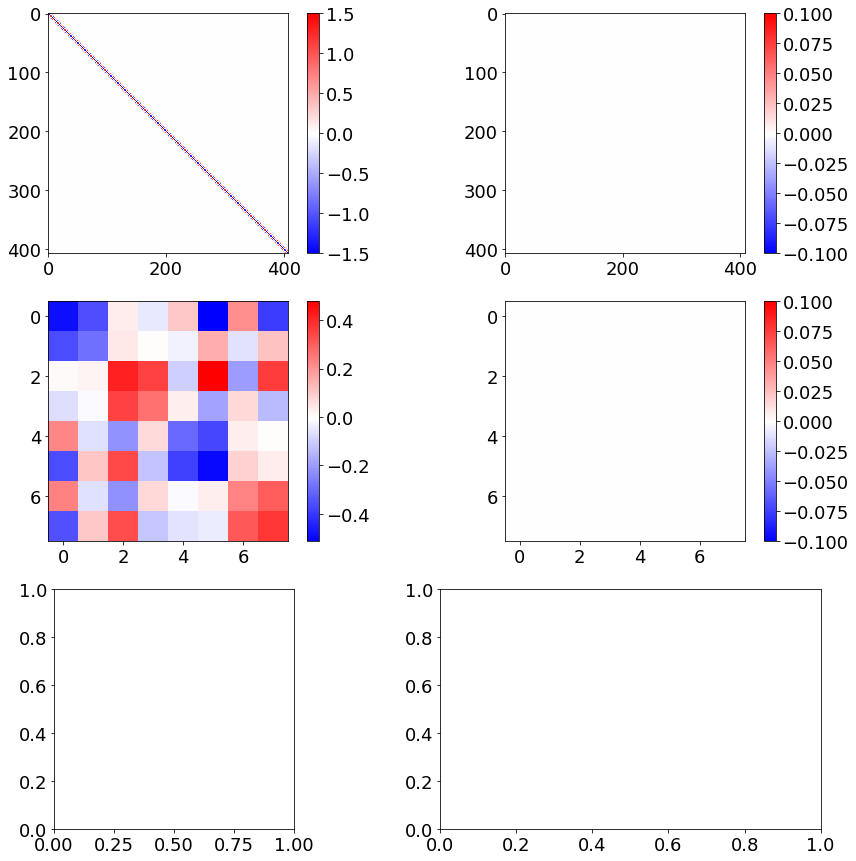

In [164]:
syst = make_system(B=1., L_link=100, L_S=6.479*50./10000., tau=1., tv=1., alpha_so=6.479/2., delta=0.25)
S = kwant.smatrix(syst, 0.)
G = kwant.greens_function(syst, 0.)
#print(S)

norm1 = colors.DivergingNorm(vcenter=0)
norm2 = colors.DivergingNorm(vcenter=0)
norm3 = colors.DivergingNorm(vcenter=0)
norm4 = colors.DivergingNorm(vcenter=0)
norm5 = colors.DivergingNorm(vcenter=0)
norm6 = colors.DivergingNorm(vcenter=0)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
im1 = ax1.imshow(np.real(syst.hamiltonian_submatrix()), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(syst.hamiltonian_submatrix()), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
im3 = ax3.imshow(np.real(G.data), cmap='bwr', interpolation='none', norm=norm3)
fig.colorbar(im3, ax=ax3)
im4 = ax4.imshow(np.imag(G.data), cmap='bwr', interpolation='none', norm=norm4)
fig.colorbar(im4, ax=ax4)
im5 = ax5.imshow(np.real(S.data), cmap='bwr', interpolation='none', norm=norm5)
fig.colorbar(im5, ax=ax5)
im6 = ax6.imshow(np.imag(S.data), cmap='bwr', interpolation='none', norm=norm6)
fig.colorbar(im6, ax=ax6)
print(G)
print('number of propagating modes')
print(G.num_propagating(0))
print(G.transmission(1, 0))

print(S)
print('S number of propagating modes')
print(S.num_propagating(0))
print(S.transmission(1, 0))

In [214]:
mat1 = syst.leads[1].inter_cell_hopping()
mat1

array([[ 1.  +0.j, -0.25+0.j,  0.  +0.j,  0.  +0.j],
       [ 0.25+0.j,  1.  +0.j,  0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j, -1.  +0.j,  0.25+0.j],
       [ 0.  +0.j,  0.  +0.j, -0.25+0.j, -1.  +0.j]])

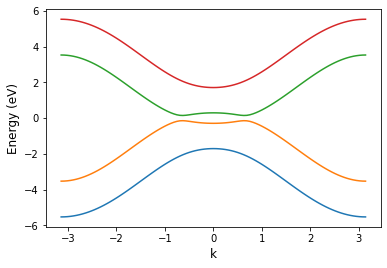

In [237]:
syst = make_system(L=3, mu=0.5, t=-1., B=1., delta=0.5, alpha_so=0.5)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x)
#plt.ylim(-2,2)


plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

In [228]:
def spectral_gap_scan(tv=-1., alpha_sov = 0.5, Lv=3):
    band_gap_array = []
    for i in np.linspace(0., 1, 1001):
        syst = make_system(B=i, phi=0.*np.pi, t=tv, alpha_so = alpha_sov, L=Lv)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,101)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
    return band_gap_array

B = 0.707
Delta = 0.0002135623730954114
[[ 0.66503562 -0.66503562]
 [ 0.66503028 -0.66503028]
 [ 0.66501427 -0.66501427]
 ...
 [ 0.14586477 -0.14586477]
 [ 0.14597681 -0.14597681]
 [ 0.14609519 -0.14609519]]


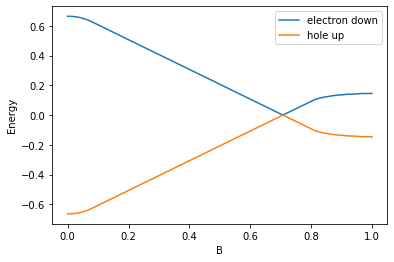

In [229]:
band_gap_array = np.array(spectral_gap_scan())
#print(np.array(band_gap_array))
plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,0], label='electron down')
plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,1], label='hole up')
plt.xlabel('B')
plt.ylabel('Energy')
plt.legend()
#plt.xlim(0.705, 0.71)

print('B = ' + str(np.argmin(band_gap_array[:,0])/1000.))
print('Delta = ' + str(np.min(band_gap_array[:,0])*2.))
print(band_gap_array)

In [230]:
def phi_scan_alt(Bv=1., tv=-1., Lv=3, tauv=0.5):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 4*np.pi, 21):
        syst = make_system(L=Lv, phi=i, B=Bv, tau=tauv, t=tv)
        energies, wavefunctions = find_boundstates(syst, -0.6, 0.6, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

[array([-0.12491642,  0.12491642]), array([-0.10152688,  0.10152688]), array([-0.07818307,  0.07818307]), array([-0.05298717,  0.05298717]), array([-0.02673563,  0.02673563]), array([-5.17814958e-16, -5.17814958e-16]), array([-0.02673563,  0.02673563]), array([-0.05298717,  0.05298717]), array([-0.07818307,  0.07818307]), array([-0.10152688,  0.10152688]), array([-0.12491642,  0.12491642]), array([-0.10152688,  0.10152688]), array([-0.07818307,  0.07818307]), array([-0.05298717,  0.05298717]), array([-0.02673563,  0.02673563]), array([3.46944695e-16, 3.46944695e-16]), array([-0.02673563,  0.02673563]), array([-0.05298717,  0.05298717]), array([-0.07818307,  0.07818307]), array([-0.10152688,  0.10152688]), array([-0.12491642,  0.12491642])]
[array([-0.11761954, -0.08334901,  0.08334901,  0.11761954]), array([-0.12374969, -0.07538328,  0.07538328,  0.12374969]), array([-0.13423118, -0.05913381,  0.05913381,  0.13423118]), array([-0.14252916, -0.04027684,  0.04027684,  0.14252916]), array

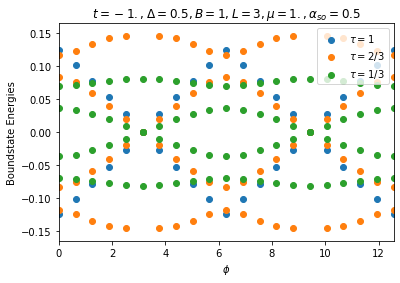

In [233]:
e_array, psi_array = phi_scan_alt(tauv=1., Lv=3)
e_array1, psi_array1 = phi_scan_alt(tauv=2./3., Lv=3)
e_array2, psi_array2 = phi_scan_alt(tauv=1./3., Lv=3)
print(e_array)
print(e_array1)
print(e_array2)

ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array)):
    for j in range(len(e_array[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array[i][j])
    for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])
plt.scatter(ex, ey, label=r'$\tau = 1$')
plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'$t=-1., \Delta=0.5, B=1, L=3, \mu=1., \alpha_{so}=0.5$')
plt.legend()

[array([-0.21635094,  0.21635094]), array([-0.21619145,  0.21619145]), array([-0.21577474,  0.21577474]), array([-0.21526132,  0.21526132]), array([-0.21484727,  0.21484727]), array([-0.21468943,  0.21468943]), array([-0.21484727,  0.21484727]), array([-0.21526132,  0.21526132]), array([-0.21577474,  0.21577474]), array([-0.21619145,  0.21619145]), array([-0.21635094,  0.21635094]), array([-0.21619145,  0.21619145]), array([-0.21577474,  0.21577474]), array([-0.21526132,  0.21526132]), array([-0.21484727,  0.21484727]), array([-0.21468943,  0.21468943]), array([-0.21484727,  0.21484727]), array([-0.21526132,  0.21526132]), array([-0.21577474,  0.21577474]), array([-0.21619145,  0.21619145]), array([-0.21635094,  0.21635094])]
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), arr

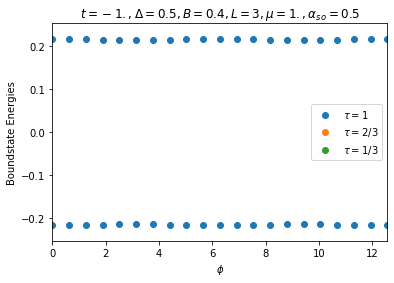

In [234]:
e_array3, psi_array3 = phi_scan_alt(Bv=0.4, tauv=1., Lv=3)
e_array4, psi_array4 = phi_scan_alt(Bv=0.4, tauv=2./3., Lv=3)
e_array5, psi_array5 = phi_scan_alt(Bv=0.4, tauv=1./3., Lv=3)
print(e_array3)
print(e_array4)
print(e_array5)

ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array3)):
    for j in range(len(e_array3[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array3[i][j])
    for j in range(len(e_array4[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array4[i][j])
    for j in range(len(e_array5[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array5[i][j])
plt.scatter(ex, ey, label=r'$\tau = 1$')
plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'$t=-1., \Delta=0.5, B=0.4, L=3, \mu=1., \alpha_{so}=0.5$')
plt.legend()

In [ ]:
def phi_scan(Bv=1., tv=-1., Lv=3, tauv=0.5):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 2*np.pi, 21):
        syst = make_system(L=Lv, phi=i, B=Bv, tau=tauv, t=tv)
        energies, wavefunctions = find_boundstates(syst, -0.6, 0.6, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays